dataset: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset/code

paper: https://ieeexplore.ieee.org/document/9224622

In [ ]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from skimage import io

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50 
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

1400 sample size (Adam optimizer) 

Take a look at U-net segmentation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def upload_tb_data(tb_size):
  np.random.seed(42)
  ran_int = list(np.random.randint(1, 3501, size=tb_size, ))

  df_t = pd.DataFrame({
      'img_path': [f'drive/MyDrive/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-{n}.png' for n in list(range(1, tb_size+1))],
      })
  df_t['class'] = np.full(df_t.shape[0], 'tuberculosis')

  df_n = pd.DataFrame({
      'img_path': [f'drive/MyDrive/TB_Chest_Radiography_Database/Normal/Normal-{n}.png' for n in ran_int],
      })
  df_n['class'] = np.full(df_n.shape[0], 'normal')


  df_nt = pd.concat([df_t, df_n], ignore_index=True)

  print(f'Dataset generated with {tb_size} tuberculosis images')
  
  return df_nt

## Setting up the image augmentation from last Lesson: 

In [ ]:
def generate_img_gen(df, training=True, x_col='img_path', y_col='class', IMG_SIZE=(224, 224), batch_size=32):
  

  if training:
    img_idg = ImageDataGenerator(rescale=1. / 255.0,
                    horizontal_flip = True, 
                    vertical_flip = False, 
                    height_shift_range= 0.1, 
                    width_shift_range=0.1, 
                    rotation_range=20, 
                    shear_range = 0.1,
                    zoom_range=0.1)
  else:
    img_idg = ImageDataGenerator(rescale=1. / 255.0)

  img_gen = img_idg.flow_from_dataframe(dataframe=df, 
                        directory=None, 
                        x_col = x_col,
                        y_col = y_col,
                        class_mode = 'binary',
                        target_size = IMG_SIZE, 
                        batch_size = batch_size,
                        )

  # # Note that the validation data should not be augmented! We only want to do some basic intensity rescaling here
  # val_idg = ImageDataGenerator(rescale=1. / 255.0)

  # val_gen = val_idg.flow_from_dataframe(dataframe=valid_df, 
  #                     directory=None, 
  #                     x_col = 'img_path',
  #                     y_col = 'class',
  #                     class_mode = 'binary',
  #                     target_size = IMG_SIZE, 
  #                     batch_size = 32) ## We've only been provided with 6 validation images

  return img_gen

## Now we'll load in VGG16 with pre-trained ImageNet weights: 

In [ ]:
def create_vgg19_model(opt, lr):

  model = VGG19(include_top=True,
                weights='imagenet')
  
  transfer_layer = model.get_layer('block5_pool')
  vgg_model = Model(inputs=model.input,
                    outputs=transfer_layer.output)
  
  ## Now, choose which layers of VGG16 we actually want to fine-tune (if any)
  ## Here, we'll freeze all but the last convolutional layer
  for layer in vgg_model.layers[0:17]:
      layer.trainable = False

  new_model = Sequential()

  # Add the convolutional part of the VGG16 model from above.
  new_model.add(vgg_model)

  # Flatten the output of the VGG16 model because it is from a
  # convolutional layer.
  new_model.add(Flatten())

  # Add a dropout-layer which may prevent overfitting and
  # improve generalization ability to unseen data e.g. the test-set.
  new_model.add(Dropout(0.5))

  # Add a dense (aka. fully-connected) layer.
  # This is for combining features that the VGG16 model has
  # recognized in the image.
  new_model.add(Dense(1024, activation='relu'))

  # Add a dropout-layer which may prevent overfitting and
  # improve generalization ability to unseen data e.g. the test-set.
  new_model.add(Dropout(0.5))

  # Add a dense (aka. fully-connected) layer.
  # This is for combining features that the VGG16 model has
  # recognized in the image.
  new_model.add(Dense(512, activation='relu'))

  # Add a dropout-layer which may prevent overfitting and
  # improve generalization ability to unseen data e.g. the test-set.
  new_model.add(Dropout(0.5))

  # Add a dense (aka. fully-connected) layer.
  # This is for combining features that the VGG16 model has
  # recognized in the image.
  new_model.add(Dense(256, activation='relu'))

  # Add a dense (aka. fully-connected) layer.
  # Change the activation function to sigmoid 
  # so output of the last layer is in the range of [0,1] 
  new_model.add(Dense(1, activation='sigmoid'))

  new_model.summary()

  ## Set our optimizer, loss function, and learning rate
  # lr 1e-4, 0.001
  print(f"Adam opt: {opt} - lr: {lr}" if opt == 'Adam' else f"SGD opt: {opt} - lr: {lr}")
  optimizer = Adam(lr=lr) if opt == 'Adam' else SGD(lr=lr, momentum=0.5) # 1e-4, 0.01, momentum = 0.5
  loss = 'binary_crossentropy'
  metrics = ['binary_accuracy']

  new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  return new_model

In [ ]:
def train_model(df_train, opt, lr, model_name, epochs=10):

  X_train, X_valid, y_train, y_valid = train_test_split(df_train, 
                                                        df_train['class'], 
                                                        test_size=0.2, 
                                                        random_state=42)
      
  train_gen = generate_img_gen(X_train, training=True)
  valid_gen = generate_img_gen(X_valid, training=False)

  new_model = create_vgg19_model(opt, lr)

  # CREATE CALLBACKS
  best_model_name = f'drive/MyDrive/STA221/models/{model_name}.h5'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(best_model_name,
                                                  save_weights_only=True,                                  
                                                  monitor='val_loss',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode='min')
  
  callbacks_list = [checkpoint]
  
  # FIT THE MODEL
  history = new_model.fit(train_gen,
                      epochs=epochs,
                      callbacks=callbacks_list,
                      validation_data=valid_gen)
  # LOAD BEST MODEL to evaluate the performance of the model
  new_model.load_weights(best_model_name)

  print('OPTIMIZER NAME:', new_model.optimizer)

  results = new_model.evaluate(valid_gen)
  results = dict(zip(new_model.metrics_names,results))

  print(results)

  N = len(history.history["loss"]) # N == epochs

  df_hist = pd.DataFrame({
      'optimizer': np.full(N, opt),
      'learning_rate': np.full(N, lr),
      'best_model_name': np.full(N, best_model_name),
      'epoch': np.arange(0, N),        
      'train_acc': history.history["binary_accuracy"],
      'val_acc': history.history["val_binary_accuracy"],
      'train_loss':  history.history["loss"],
      'val_loss': history.history["val_loss"],
      'val_test_acc':  np.full(N, results['binary_accuracy']),
      'val_test_loss': np.full(N, results['loss']),
      })

  return df_hist


def train_model_kfold(df_train, opt, model_name, epochs=10, n_folds=5):

  
  kfold = KFold(n_folds, shuffle=True, random_state=42)
  
  fold_var = 1
  df_hist = pd.DataFrame()
  
  for train_ix, valid_ix in kfold.split(df_train): # 1, 2, 3, 4, 5
    
    train_gen = generate_img_gen(df_train.iloc[train_ix], training=True)
    valid_gen = generate_img_gen(df_train.iloc[valid_ix], training=False)

    new_model = create_vgg19_model(opt)

    # CREATE CALLBACKS
    best_model_name = f'drive/MyDrive/STA221/models/{model_name}.hdf5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(best_model_name,
                                                    save_weights_only=True,                                  
                                                    monitor='val_loss',
                                                    verbose=1,
                                                    save_best_only=True,
                                                    mode='min')
    
    callbacks_list = [checkpoint]
    
    # FIT THE MODEL
    history = new_model.fit(train_gen,
                        epochs=epochs,
                        callbacks=callbacks_list,
                        validation_data=valid_gen)
    # LOAD BEST MODEL to evaluate the performance of the model
    new_model.load_weights(best_model_name)

    print('OPTIMIZER NAME:', new_model.optimizer.__str__())

    results = new_model.evaluate(valid_gen)
    results = dict(zip(new_model.metrics_names,results))

    print(results)

    N = len(history.history["loss"]) # N == epochs

    df_hist_i = pd.DataFrame({
        'optimizer': np.full(N, opt),
        'best_model_name': np.full(N, best_model_name),
        'n_folds': np.full(N, n_folds),
        'fold': np.full(N, fold_var),
        'epoch': np.arange(0, N),        
        'train_acc': history.history["binary_accuracy"],
        'val_acc': history.history["val_binary_accuracy"],
        'train_loss':  history.history["loss"],
        'val_loss': history.history["val_loss"],
        'val_test_acc':  np.full(N, results['binary_accuracy']),
        'val_test_loss': np.full(N, results['loss']),
       })
    
    df_hist = pd.concat([df_hist, df_hist_i], ignore_index=True)
        
    fold_var += 1

  return df_hist


def evaluate_model(X_test, opt, lr, model_name):

  print(f'Test set generated with {X_test.shape[0]} images')
  test_gen = generate_img_gen(X_test, training=False)

  new_model = create_vgg19_model(opt, lr)

  new_model.load_weights(model_name)

  results = new_model.evaluate(test_gen)
  results = dict(zip(new_model.metrics_names,results))

  return results

In [ ]:
# df_hist = pd.DataFrame()
df_hist = pd.read_csv('drive/MyDrive/STA221/final_vgg19_history_train_results.csv')

lr_dict = {'Adam': 0.0001, 'SGD': 0.01}

for opt in ['Adam', 'SGD']: # ['Adam', 'SGD']

  lr = lr_dict[opt]

  for sample_size in [1000, 1400]:# 200, 500, 1000, 1400

    df_i = upload_tb_data(tb_size=int(sample_size/2)) 
    
    X_train, X_test, y_train, y_test = train_test_split(df_i, 
                                                        df_i['class'], 
                                                        test_size=0.2, 
                                                        random_state=42)

    df_hist_i = train_model(X_train,
                            opt=opt,
                            lr=lr,
                            model_name=f'{opt}_sample_size_{sample_size}',
                            epochs=10,
                            )

    df_hist_i['sample_size'] = np.full(df_hist_i.shape[0],
                                            sample_size)
    
    best_model_name = df_hist_i['best_model_name'].unique()[0]

    print(best_model_name)                                              
                                                  
    results = evaluate_model(X_test, opt, lr, best_model_name)

    df_hist_i['test_acc'] = np.full(df_hist_i.shape[0], 
                                    results['binary_accuracy'])
    
    df_hist_i['test_loss'] = np.full(df_hist_i.shape[0], 
                                    results['loss'])
    
    df_hist = pd.concat([df_hist, df_hist_i], ignore_index=True)

    df_hist.to_csv('drive/MyDrive/STA221/final_vgg19_history_train_results.csv', index=False)

Dataset generated with 500 tuberculosis images
Found 640 validated image filenames belonging to 2 classes.
Found 160 validated image filenames belonging to 2 classes.
Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_64 (Functional)       (None, 7, 7, 512)         20024384  
                                                                 
 flatten_64 (Flatten)        (None, 25088)             0         
                                                                 
 dropout_192 (Dropout)       (None, 25088)             0         
                                                                 
 dense_256 (Dense)           (None, 1024)              25691136  
                                                                 
 dropout_193 (Dropout)       (None, 1024)              0         
                                                                 
 dense_257 (Dense)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 0.6554 - binary_accuracy: 0.6516
Epoch 1: val_loss improved from inf to 0.20425, saving model to drive/MyDrive/STA221/models/Adam_sample_size_1000.h5
20/20 [==============================] - 198s 10s/step - loss: 0.6554 - binary_accuracy: 0.6516 - val_loss: 0.2043 - val_binary_accuracy: 0.9250
Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 0.3336 - binary_accuracy: 0.8578
Epoch 2: val_loss improved from 0.20425 to 0.18231, saving model to drive/MyDrive/STA221/models/Adam_sample_size_1000.h5
20/20 [==============================] - 18s 904ms/step - loss: 0.3336 - binary_accuracy: 0.8578 - val_loss: 0.1823 - val_binary_accuracy: 0.9187
Epoch 3/10
20/20 [==============================] - ETA: 0s - loss: 0.2852 - binary_accuracy: 0.8844
Epoch 3: val_loss did not improve from 0.18231
20/20 [==============================] - 15s 773ms/step - loss: 0.2852 - binary_accuracy: 0.8844 - val_loss: 0.2129 - val

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 0.8314 - binary_accuracy: 0.5266
Epoch 1: val_loss improved from inf to 0.50694, saving model to drive/MyDrive/STA221/models/SGD_sample_size_1000.h5
20/20 [==============================] - 17s 791ms/step - loss: 0.8314 - binary_accuracy: 0.5266 - val_loss: 0.5069 - val_binary_accuracy: 0.8625
Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 0.5511 - binary_accuracy: 0.7203
Epoch 2: val_loss did not improve from 0.50694
20/20 [==============================] - 15s 756ms/step - loss: 0.5511 - binary_accuracy: 0.7203 - val_loss: 0.5927 - val_binary_accuracy: 0.6625
Epoch 3/10
20/20 [==============================] - ETA: 0s - loss: 0.4386 - binary_accuracy: 0.8125
Epoch 3: val_loss improved from 0.50694 to 0.17383, saving model to drive/MyDrive/STA221/models/SGD_sample_size_1000.h5
20/20 [==============================] - 16s 817ms/step - loss: 0.4386 - binary_accuracy: 0.8125 - val_loss: 0.1738 - val_

Dataset generated with 100 tuberculosis images
Found 40 validated image filenames belonging to 2 classes.
Model: "sequential_192"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_192 (Functional)      (None, 7, 7, 512)         20024384  
                                                                 
 flatten_192 (Flatten)       (None, 25088)             0         
                                                                 
 dropout_576 (Dropout)       (None, 25088)             0         
                                                                 
 dense_768 (Dense)           (None, 1024)              25691136  
                                                                 
 dropout_577 (Dropout)       (None, 1024)              0         
                                                                 
 dense_769 (Dense)           (None, 512)               524800    
            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Confusion Matrix
[[19  0]
 [ 1 20]]
Classification Report
0.975
              precision    recall  f1-score   support

      normal       0.95      1.00      0.97        19
tuberculosis       1.00      0.95      0.98        21

    accuracy                           0.97        40
   macro avg       0.97      0.98      0.97        40
weighted avg       0.98      0.97      0.98        40

[0.         0.         0.         0.         0.         0.26315789
 0.26315789 1.        ] [0.         0.04761905 0.0952381  0.28571429 0.95238095 0.95238095
 1.         1.        ] [1.9999996e+00 9.9999964e-01 9.9999928e-01 9.9999905e-01 8.8319278e-01
 7.9371449e-07 1.7670443e-07 2.3796831e-13]
Dataset generated with 250 tuberculosis images
Found 100 validated image filenames belonging to 2 classes.
Model: "sequential_193"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_193 (Functional)      (None, 7, 7, 512)   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Confusion Matrix
[[53  1]
 [ 0 46]]
Classification Report
0.99
              precision    recall  f1-score   support

      normal       1.00      0.98      0.99        54
tuberculosis       0.98      1.00      0.99        46

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

[0.         0.         0.         0.01851852 0.01851852 0.05555556
 0.09259259 1.        ] [0.         0.02173913 0.97826087 0.97826087 1.         1.
 1.         1.        ] [1.9999919e+00 9.9999189e-01 9.8830569e-01 8.2620144e-01 6.6823226e-01
 1.5018502e-01 9.2610911e-02 1.2966220e-10]
Dataset generated with 500 tuberculosis images
Found 200 validated image filenames belonging to 2 classes.
Model: "sequential_194"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_194 (Functional)      (None, 7, 7, 512)         200

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Confusion Matrix
[[104   0]
 [  5  91]]
Classification Report
0.975
              precision    recall  f1-score   support

      normal       0.95      1.00      0.98       104
tuberculosis       1.00      0.95      0.97        96

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200

[0.         0.         0.         0.         0.         0.
 0.         0.         0.02884615 0.02884615 0.13461538 0.15384615
 0.46153846 0.48076923 1.        ] [0.         0.22916667 0.29166667 0.30208333 0.32291667 0.35416667
 0.375      0.96875    0.96875    1.         1.         1.
 1.         1.         1.        ] [2.0000000e+00 1.0000000e+00 9.9999988e-01 9.9999976e-01 9.9999964e-01
 9.9999928e-01 9.9999881e-01 3.5614270e-01 4.2033680e-02 2.8587110e-02
 1.7218021e-04 1.3196633e-04 1.7237387e-06 1.5405134e-06 3.4112064e-15]
Dataset generated with 700 tuberculosis images
Found 280 validated im

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Confusion Matrix
[[140   0]
 [  2 138]]
Classification Report
0.9928571428571429
              precision    recall  f1-score   support

      normal       0.99      1.00      0.99       140
tuberculosis       1.00      0.99      0.99       140

    accuracy                           0.99       280
   macro avg       0.99      0.99      0.99       280
weighted avg       0.99      0.99      0.99       280

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.03571429 0.03571429 0.35714286 0.37142857 0.42857143 0.44285714
 0.65       0.66428571 0.81428571 0.82857143 1.        ] [0.         0.45       0.48571429 0.50714286 0.52142857 0.53571429
 0.55       0.55714286 0.57142857 0.59285714 0.60714286 0.99285714
 0.99285714 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.        ] [2.0000000e+00 1.0000000e+00 9.9999988e-01 9.9999952e-01 9.9999928e-01
 9.9999893e-01 9.9999881e-01 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Confusion Matrix
[[18  1]
 [ 1 20]]
Classification Report
0.95
              precision    recall  f1-score   support

      normal       0.95      0.95      0.95        19
tuberculosis       0.95      0.95      0.95        21

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40

[0.         0.         0.         0.05263158 0.05263158 0.36842105
 0.36842105 1.        ] [0.         0.04761905 0.85714286 0.85714286 0.95238095 0.95238095
 1.         1.        ] [1.9974457e+00 9.9744570e-01 9.5807505e-01 6.7666507e-01 5.4006845e-01
 5.6232227e-04 5.1314809e-04 2.0694704e-05]
Dataset generated with 250 tuberculosis images
Found 100 validated image filenames belonging to 2 classes.
Model: "sequential_197"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_197 (Functional)      (None, 7, 7, 512)    

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Confusion Matrix
[[51  3]
 [ 1 45]]
Classification Report
0.96
              precision    recall  f1-score   support

      normal       0.98      0.94      0.96        54
tuberculosis       0.94      0.98      0.96        46

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100

[0.         0.         0.         0.03703704 0.14814815 0.14814815
 1.        ] [0.         0.02173913 0.97826087 0.97826087 0.97826087 1.
 1.        ] [1.9950492e+00 9.9504918e-01 8.1241316e-01 6.5543312e-01 2.0559560e-01
 1.9679725e-01 3.3540593e-04]
Dataset generated with 500 tuberculosis images
Found 200 validated image filenames belonging to 2 classes.
Model: "sequential_198"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_198 (Functional)      (None, 7, 7, 512)         20024384  
                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Confusion Matrix
[[102   2]
 [  2  94]]
Classification Report
0.98
              precision    recall  f1-score   support

      normal       0.98      0.98      0.98       104
tuberculosis       0.98      0.98      0.98        96

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200

[0.         0.         0.         0.         0.         0.00961538
 0.00961538 0.01923077 0.01923077 0.03846154 0.03846154 0.06730769
 0.08653846 0.09615385 0.09615385 0.75961538 0.77884615 1.        ] [0.         0.01041667 0.32291667 0.34375    0.92708333 0.92708333
 0.94791667 0.94791667 0.97916667 0.97916667 0.98958333 0.98958333
 0.98958333 0.98958333 1.         1.         1.         1.        ] [1.9999911e+00 9.9999106e-01 9.9981505e-01 9.9980897e-01 8.8705784e-01
 8.7134463e-01 7.9100442e-01 7.2541916e-01 6.0987848e-01 4.2975757e-01
 4.0135598e-01 1.8940970e-01 1.7796117e-01 1.6079244e-01 1.5

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Confusion Matrix
[[138   2]
 [  4 136]]
Classification Report
0.9785714285714285
              precision    recall  f1-score   support

      normal       0.97      0.99      0.98       140
tuberculosis       0.99      0.97      0.98       140

    accuracy                           0.98       280
   macro avg       0.98      0.98      0.98       280
weighted avg       0.98      0.98      0.98       280

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00714286
 0.00714286 0.01428571 0.01428571 0.02857143 0.02857143 0.06428571
 0.06428571 0.12142857 0.13571429 0.14285714 0.15714286 0.20714286
 0.22142857 0.23571429 0.25       0.32857143 0.34285714 1.        ] [0.         0.00714286 0.01428571 0.03571429 0.05       0.06428571
 0.08571429 0.11428571 0.12142857 0.15       0.18571429 0.2
 0.20714286 0.22142857 0.23571429 0.25       0.94285714 0.94285714
 0.97142857

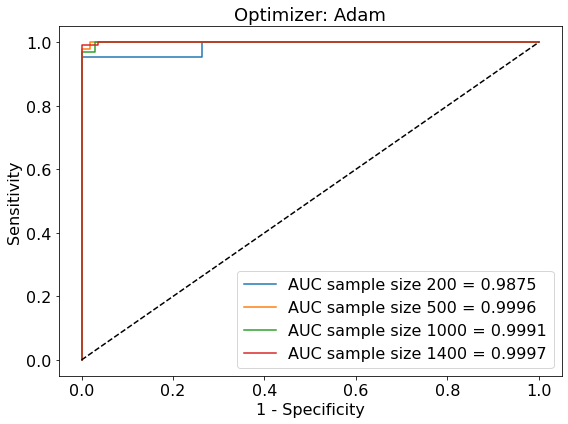

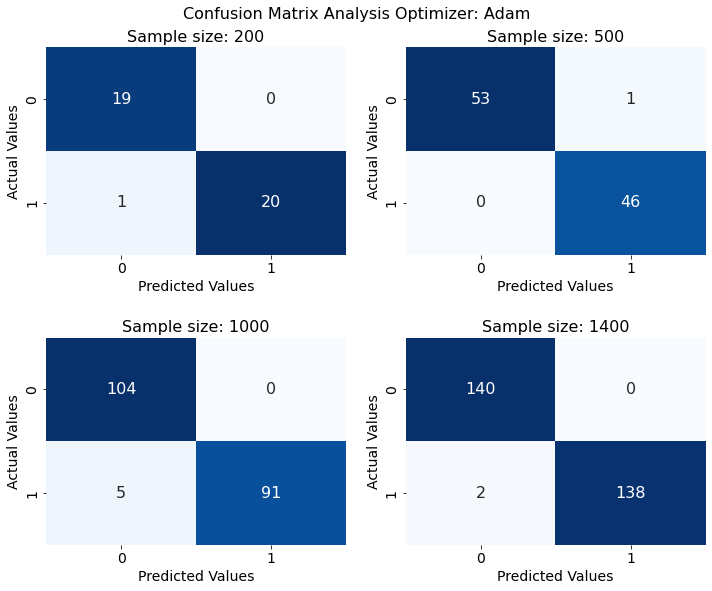

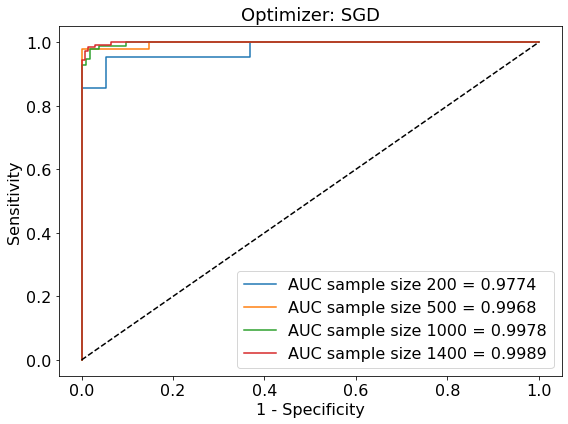

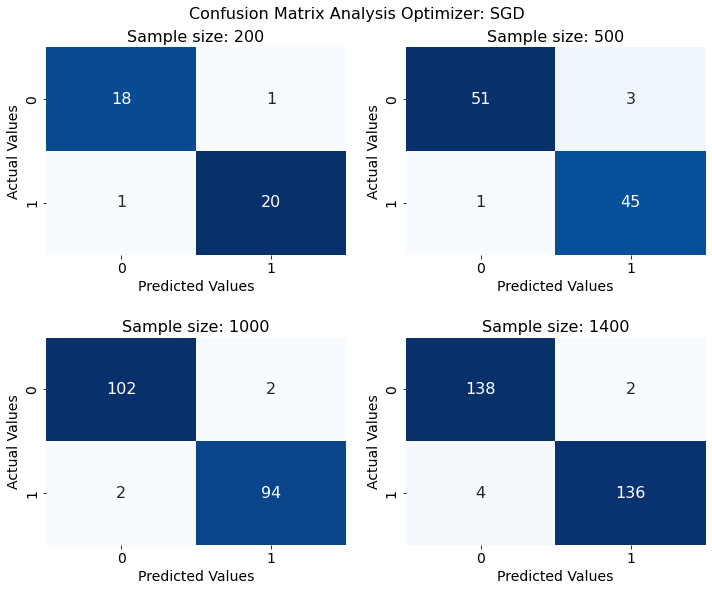

In [ ]:
df_hist = pd.read_csv('drive/MyDrive/STA221/final_vgg19_history_train_results.csv')

df_table = pd.DataFrame()

for opt in df_hist['optimizer'].unique(): # ['Adam', 'SGD']

  f, ax = plt.subplots(figsize=(8, 6))

  confusion_matrix_list = []

  for sample_size in df_hist['sample_size'].unique():
    
    df_i = upload_tb_data(tb_size=int(sample_size/2)) 
      
    X_train, X_test, y_train, y_test = train_test_split(df_i, 
                                                        df_i['class'], 
                                                        test_size=0.2, 
                                                        random_state=42)

    img_idg = ImageDataGenerator(rescale=1. / 255.0)

    test_gen = img_idg.flow_from_dataframe(dataframe=X_test, 
                          directory=None, 
                          x_col = 'img_path',
                          y_col = 'class',
                          class_mode = 'binary',
                          target_size = (224, 224),
                          batch_size = 32,
                          shuffle = False
                          )

    current_hist = df_hist[(df_hist['sample_size'] == sample_size) & (df_hist['optimizer'] == opt)]

    new_model = create_vgg19_model(opt, current_hist['learning_rate'].unique()[0])

    best_model = current_hist['best_model_name'].unique()[0]

    print(best_model)

    new_model.load_weights(best_model)

    y_true = test_gen.classes

    y_pred = new_model.predict(test_gen)

    y_pred_class = 1*(y_pred >= 0.5)

    cm = confusion_matrix(y_true, y_pred_class)

    print('Confusion Matrix')
    print(cm)
    print('Classification Report')
    target_names=list(test_gen.class_indices.keys())
    print(accuracy_score(y_true, y_pred_class))
    print(classification_report(y_true, y_pred_class, target_names=target_names))

    confusion_matrix_list.append(cm)

    TN = cm[0][0]
    TP = cm[1][1]
    FP = cm[0][1]
    FN = cm[1][0]

    accuracy = (TP + TN)/ (TP + TN + FP + FN)
    precision = TP/(TP+FP)
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN + FP)
    # f1_score_1 = (2*TP)/(2*TP + FN + FP)
    f1_score = 2*((precision*sensitivity)/(precision + sensitivity))

    df_table = pd.concat([df_table, pd.DataFrame({
        'Optimizer': [opt],
        'Sample size': [sample_size],    
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Sensitivity': [sensitivity],
        'Specificity': [specificity],
        'F1 Score': [f1_score]
        })], ignore_index=True)
    

    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred)
    print(fpr_keras, tpr_keras, thresholds_keras)

    auc_keras = auc(fpr_keras, tpr_keras)
    
    ax.plot(fpr_keras, tpr_keras, label=f'AUC sample size {sample_size} = {np.round(auc_keras, 4)}')

  ax.plot([0, 1], [0, 1], 'k--')
  ax.set_xlabel('1 - Specificity', fontsize=16)
  ax.set_ylabel('Sensitivity', fontsize=16)
  ax.tick_params(axis='both', labelsize=16)
  title = f'Optimizer: {opt}'
  ax.set_title(title, fontsize=18)
  ax.legend(loc='best', fontsize=16)
  plt.tight_layout()
  plt.savefig(f"roc_curve_{opt}.pdf", dpi=300)
   
  f, axs = plt.subplots(2, 2, figsize=(10, 8))

  for cm, axi, sample_size in zip(confusion_matrix_list, axs.flat, df_hist['sample_size'].unique()):
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', 
              ax=axi, annot_kws={"fontsize":16}, cbar=False)
    title = f'Sample size: {sample_size}'
    axi.set_title(title, fontsize=16);
    axi.set_xlabel('Predicted Values', fontsize=14)
    axi.set_ylabel('Actual Values', fontsize=14)

    axi.tick_params(axis='both', labelsize=14)

  f.suptitle(f'Confusion Matrix Analysis Optimizer: {opt}', fontsize=16, y=1.02)
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.2, hspace=0.4)
  plt.savefig(f"{opt}_confusion_matrix_plot.pdf", dpi=300)

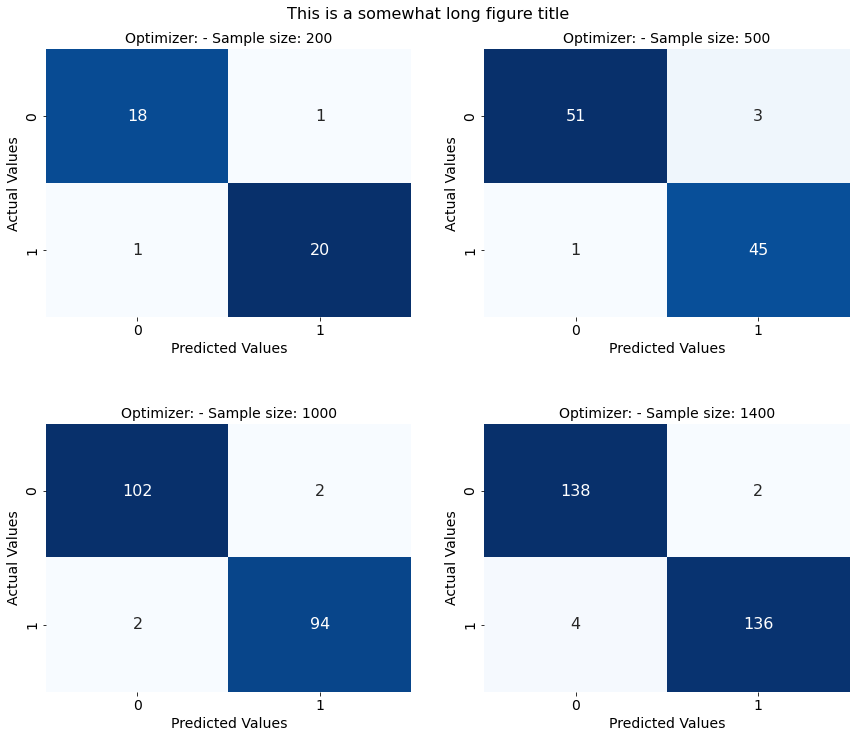

In [ ]:
f, axs = plt.subplots(2, 2, figsize=(12, 10))


for cm, axi, sample_size in zip(confusion_matrix_list, axs.flat, df_hist['sample_size'].unique()):
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', 
              ax=axi, annot_kws={"fontsize":16}, cbar=False)

  title = f'Optimizer: - Sample size: {sample_size}'
  axi.set_title(title, fontsize=14);
  axi.set_xlabel('Predicted Values', fontsize=14)
  axi.set_ylabel('Actual Values', fontsize=14)

  axi.tick_params(axis='both', labelsize=14)


plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.4)

In [ ]:
print((df_table.groupby(['Sample size', 'Optimizer']).mean()*100).round(2).to_latex())

\begin{tabular}{llrrrrr}
\toprule
     &     &  Accuracy &  Precision &  Sensitivity &  Specificity &  F1 Score \\
Sample size & Optimizer &           &            &              &              &           \\
\midrule
200  & Adam &     97.50 &     100.00 &        95.24 &       100.00 &     97.56 \\
     & SGD &     95.00 &      95.24 &        95.24 &        94.74 &     95.24 \\
500  & Adam &     99.00 &      97.87 &       100.00 &        98.15 &     98.92 \\
     & SGD &     96.00 &      93.75 &        97.83 &        94.44 &     95.74 \\
1000 & Adam &     97.50 &     100.00 &        94.79 &       100.00 &     97.33 \\
     & SGD &     98.00 &      97.92 &        97.92 &        98.08 &     97.92 \\
1400 & Adam &     99.29 &     100.00 &        98.57 &       100.00 &     99.28 \\
     & SGD &     97.86 &      98.55 &        97.14 &        98.57 &     97.84 \\
\bottomrule
\end{tabular}

